# Intel Image dataset: Exploratory Data Analysis

This notebook outlines steps to peform Exploratory Data Analysis (EDA) to explore the image dataset.

The image data used is the Intel Image Classification set from Kaggle: https://www.kaggle.com/puneet6060/intel-image-classification

This Data contains around 25k images of size 150x150 distributed under 6 categories:
- buildings: 0
- forest: 1
- glacier: 2
- mountain: 3
- sea: 4
- street: 5 


**Import libraries and set configuration**

In [1]:
import os
import shutil
import zipfile
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# enable image display in Jupyter and set float format
%matplotlib inline
from IPython.display import Image, display
pd.options.display.float_format = "{:,.0f}".format

**Navigation**

The data has been downloaded from Kaggle as a zip archive. Within this, the images have been organised into train, test and prediction folders. The train and test folders also have further subdirectories where images have been sorted into their respective classes (they have been labelled already). Let's begin by create path variables to point at all these locations.

In [3]:
base_dir = r'C:\Users\eddlo\Python\Projects\TF-images'
data_dir = os.path.join(base_dir,'data')

In [4]:
# Unzip folder to data directory (commented out as only do once)
#with zipfile.ZipFile(os.path.join(data_dir,'archive.zip'), 'r') as my_zip:
#  my_zip.extractall(data_dir)

In [5]:
# set paths to train, test and pred folders
dir_train = os.path.join(data_dir,'seg_train','seg_train')
dir_test = os.path.join(data_dir,'seg_test','seg_test')
dir_pred = os.path.join(data_dir,'seg_pred','seg_pred')

# set paths for each class in train folder
dir_train_buildings = os.path.join(dir_train,'buildings')
dir_train_forest = os.path.join(dir_train,'forest')
dir_train_glacier = os.path.join(dir_train,'glacier')
dir_train_mountain = os.path.join(dir_train,'mountain')
dir_train_sea = os.path.join(dir_train,'sea')
dir_train_street = os.path.join(dir_train,'street')

# do same for test folder
dir_test_buildings = os.path.join(dir_test,'buildings')
dir_test_forest = os.path.join(dir_test,'forest')
dir_test_glacier = os.path.join(dir_test,'glacier')
dir_test_mountain = os.path.join(dir_test,'mountain')
dir_test_sea = os.path.join(dir_test,'sea')
dir_test_street = os.path.join(dir_test,'street')

**Explore the data in the training set**

Firstly, let's look at how many images there are of each class in the training set, and display an example of each one.

There are 2191 images of buildings in the training set. Sample:


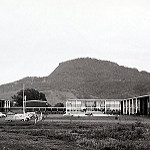

There are 2271 images of forests in the training set. Sample:


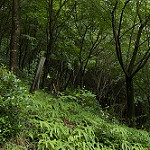

There are 2404 images of glaciers in the training set. Sample:


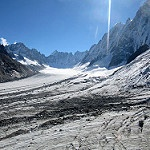

There are 2512 images of mountains in the training set. Sample:


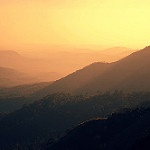

There are 2274 images of seas in the training set. Sample:


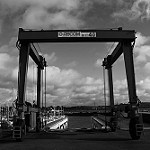

There are 2382 images of streets in the training set. Sample:


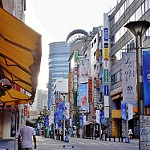

In [6]:
# Look at sample images of each class
print(f"There are {len(os.listdir(dir_train_buildings))} images of buildings in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_buildings, os.listdir(dir_train_buildings)[0])}"))
print(f"There are {len(os.listdir(dir_train_forest))} images of forests in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_forest, os.listdir(dir_train_forest)[0])}"))
print(f"There are {len(os.listdir(dir_train_glacier))} images of glaciers in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_glacier, os.listdir(dir_train_glacier)[0])}"))
print(f"There are {len(os.listdir(dir_train_mountain))} images of mountains in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_mountain, os.listdir(dir_train_mountain)[0])}"))
print(f"There are {len(os.listdir(dir_train_sea))} images of seas in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_sea, os.listdir(dir_train_sea)[0])}"))
print(f"There are {len(os.listdir(dir_train_street))} images of streets in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_street, os.listdir(dir_train_street)[0])}"))

It would be useful to understand the balance of classes in both training and test sets, and how the data has been split between training and testing. 

In [7]:
dirs_train = [dir_train_buildings,dir_train_forest,dir_train_glacier,dir_train_mountain,dir_train_sea,dir_train_street]
dirs_test = [dir_test_buildings,dir_test_forest,dir_test_glacier,dir_test_mountain,dir_test_sea,dir_test_street]
cols = ['buildings','forests','glaciers','mountains','seas','streets']

tot_train = sum([len(os.listdir(d)) for d in dirs_train])
tot_test = sum([len(os.listdir(d)) for d in dirs_test])
    
train_counts = [[len(os.listdir(d)),(len(os.listdir(d))/tot_train)*100] for d in dirs_train]
test_counts = [[len(os.listdir(d)),(len(os.listdir(d))/tot_test)*100] for d in dirs_test]

In [8]:
class_counts_train = pd.DataFrame(data=np.array(train_counts).T,columns=cols)
class_counts_train['Training data'] = ['Count','Proportion (%)']
class_counts_train.set_index('Training data',inplace=True)

class_counts_test = pd.DataFrame(data=np.array(test_counts).T,columns=cols)
class_counts_test['Test data'] = ['Count','Proportion (%)']
class_counts_test.set_index('Test data',inplace=True)

print(class_counts_train)
print('\n')
print(class_counts_test)
print('\n')
print(f"The training split is {100*tot_train/(tot_train+tot_test):.2f}% of the total dataset")

                buildings  forests  glaciers  mountains  seas  streets
Training data                                                         
Count               2,191    2,271     2,404      2,512 2,274    2,382
Proportion (%)         16       16        17         18    16       17


                buildings  forests  glaciers  mountains  seas  streets
Test data                                                             
Count                 437      474       553        525   510      501
Proportion (%)         15       16        18         18    17       17


The training split is 82.39% of the total dataset


**Simple subset of data**

Move some files into a separate directory to reduce problem to simple binary classification as a learning exercise.

In [9]:
# define paths to separate directories
dir_train_sub = os.path.join(data_dir,'sub_train')
dir_test_sub = os.path.join(data_dir, 'sub_test')

In [47]:
# create new folders (only run once)
os.makedirs(os.path.join(data_dir,'sub_train/forest'))
os.makedirs(os.path.join(data_dir,'sub_test/forest'))
os.makedirs(os.path.join(data_dir,'sub_train/sea'))
os.makedirs(os.path.join(data_dir,'sub_test/sea'))

In [53]:
# copy 500 files for each class for training, and 50 of each for validation (forest)
for idx, file in enumerate(os.listdir(dir_train_forest)[:550]):
    if idx < 500:
        shutil.copy(os.path.join(dir_train_forest,file),os.path.join(data_dir,'sub_train/forest'))
    else:
        shutil.copy(os.path.join(dir_train_forest,file),os.path.join(data_dir,'sub_test/forest'))

In [54]:
# copy 500 files for each class for training, and 50 of each for validation (sea)
for idx, file in enumerate(os.listdir(dir_train_sea)[:550]):
    if idx < 500:
        shutil.copy(os.path.join(dir_train_sea,file),os.path.join(data_dir,'sub_train/sea'))
    else:
        shutil.copy(os.path.join(dir_train_sea,file),os.path.join(data_dir,'sub_test/sea'))

### Data cleaning

Excellent, we have balanced class sizes in the training and test sets. Now we should investigate if any data cleaning is required?
- Look for corrupt files (size smaller than 1 byte)
- Look for files without an extension *.jpg

In [10]:
# search in all directories for files less than 1 byte
tot_err = 0
for path in Path(data_dir).rglob('*.jpg'):
    if os.path.getsize(path) < 1:
        tot_err+=1
assert tot_err==0

In [14]:
# find number of files in the prediction set
tot_pred = 0
for base, dirs, files in os.walk(dir_pred):
    for Files in files:
        tot_pred += 1

# search in all directories for files with the .jpg extension and check this against total number of files
count_jpg=0
for directory in [dir_train, dir_test, dir_pred]:
    for path in Path(directory).rglob('*.jpg'):
        count_jpg+=1


assert count_jpg==tot_train+tot_test+tot_pred